# Ford GoBike System Data
## by Luciano Besada
## Introduction:
Bay Wheels is a regional public bicycle sharing system in California's San Francisco Bay Area. It is operated by Motivate in a partnership with the Metropolitan Transportation Commission and the Bay Area Air Quality Management District. Bay Wheels is the first regional and large-scale bicycle sharing system deployed in California and on the West Coast of the United States. It was established as Bay Area Bike Share in August 2013. As of January 2018, the Bay Wheels system had over 2,600 bicycles in 262 stations across San Francisco, East Bay and San Jose.<br>
The bicycles are available 24 hours a day, seven days a week for periods ranging from a single ride (up to 30 minutes) to a day pass, in 30-minute increments, or customers can purchase an annual subscription which gives them unlimited rides up to 45-minutes in duration. Single rides cost 2 dollars per trip, day passes cost 10 dollars per day, and memberships cost 15 dollars per month or 149 dollars per year.<br>
Source [Wikipedia](https://en.wikipedia.org/wiki/Bay_Wheels)

### Preliminary Wrangling

> This data set includes information about individual rides made in a bike-sharing system covering the greater San Francisco Bay area.

In [400]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = None
pd.options.display.max_colwidth = None
pd.options.display.max_columns = None
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sb
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:95% !important;}</style>"))
from geopy.distance import geodesic

## 1. Gathering data:
Data available in a CSV file. 

In [2]:
df = pd.read_csv("fordgobike-tripdata.csv")

## Assessing data:
### 1a. Visual assessment:

In [3]:
df.sample(5)

duration_sec                start_time                  end_time  \
175186           607  2019-02-02 15:07:32.0670  2019-02-02 15:17:40.0620   
15849            573  2019-02-27 09:00:08.6240  2019-02-27 09:09:41.8760   
34437            114  2019-02-24 00:38:22.3750  2019-02-24 00:40:17.0590   
180716           756  2019-02-01 10:09:51.8320  2019-02-01 10:22:28.7990   
103670           716  2019-02-14 11:48:10.2150  2019-02-14 12:00:06.9410   

        start_station_id           start_station_name  start_station_latitude  \
175186             126.0                  Esprit Park               37.761634   
15849              356.0  Valencia St at Clinton Park               37.769188   
34437              147.0       29th St at Tiffany Ave               37.744067   
180716              70.0       Central Ave at Fell St               37.773311   
103670             280.0    San Fernando St at 7th St               37.337122   

        start_station_longitude  end_station_id  \
175186              -122.390648           126.0   
15849               -122.422285             3.0   
34437               -122.421472           145.0   
180716              -122.444293            43.0   
103670              -121.883215           296.0   

                                          end_station_name  \
175186                                         Esprit Park   
15849         Powell St BART Station (Market St at 4th St)   
34437                                 29th St at Church St   
180716  San Francisco Public Library (Grove St at Hyde St)   
103670                               5th St at Virginia St   

        end_station_latitude  end_station_longitude  bike_id   user_type  \
175186             37.761634            -122.390648     5531    Customer   
15849              37.786375            -122.404904     4390  Subscriber   
34437              37.743684            -122.426806     6399  Subscriber   
180716             37.778768            -122.415929      559  Subscriber   
103670             37.325998            -121.877120     1086  Subscriber   

        member_birth_year member_gender bike_share_for_all_trip  
175186             1996.0          Male                      No  
15849              1982.0          Male                      No  
34437              1998.0          Male                      No  
180716             1983.0          Male                      No  
103670             1996.0        Female                     Yes

### 1b. Programmatic assessment:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183412 entries, 0 to 183411
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   duration_sec             183412 non-null  int64  
 1   start_time               183412 non-null  object 
 2   end_time                 183412 non-null  object 
 3   start_station_id         183215 non-null  float64
 4   start_station_name       183215 non-null  object 
 5   start_station_latitude   183412 non-null  float64
 6   start_station_longitude  183412 non-null  float64
 7   end_station_id           183215 non-null  float64
 8   end_station_name         183215 non-null  object 
 9   end_station_latitude     183412 non-null  float64
 10  end_station_longitude    183412 non-null  float64
 11  bike_id                  183412 non-null  int64  
 12  user_type                183412 non-null  object 
 13  member_birth_year        175147 non-null  float64
 14  memb

In [5]:
df.duplicated().sum() # No rows duplicated

0

In [95]:
# Checking unique values
unique_counts = pd.DataFrame.from_records([(col, df[col].nunique()) for col in df.columns],\
                                          columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])
unique_counts

Column_Name  Num_Unique
12                user_type           2
15  bike_share_for_all_trip           2
14            member_gender           3
13        member_birth_year          75
3          start_station_id         329
4        start_station_name         329
7            end_station_id         329
8          end_station_name         329
5    start_station_latitude         334
6   start_station_longitude         335
9      end_station_latitude         335
10    end_station_longitude         335
11                  bike_id        4646
0              duration_sec        4752
2                  end_time      183397
1                start_time      183401

- Seems like there are 4646 number of bikes available for San Francisco area
- Data collected from 329 different stations
- Users gender divided into 3 main categories

In [6]:
print(np.unique(df.user_type.values)) # The two types of users

['Customer' 'Subscriber']


In [7]:
df.member_gender.value_counts() # The three users gender

Male      130651
Female     40844
Other       3652
Name: member_gender, dtype: int64

In [8]:
df.bike_share_for_all_trip.value_counts() # I can see most of the times customers did not shared their bikes

No     166053
Yes     17359
Name: bike_share_for_all_trip, dtype: int64

In [9]:
print(df.start_time.values.min()) # Time period is for February 2019
print(df.start_time.values.max())

2019-02-01 00:00:20.6360
2019-02-28 23:59:18.5480


### Quality issues:
- Columns _start_time_ and _end_time_ are in object format.
- All identification columns such as _start_station_id, end_station_id_ , and _bike_id_ should be object type.
- Columns _member_gender_ and _user_type_ should better storage as categorical data. 
- I could add a new column _customer_age_ (from column _member_birth_year_ ) to implement further analysis.
- Column _member_birth_year_ should be int.
- Add features such as _week_day_ and _total_distance_ traveled.


### Tidiness issues:
- Columns _start_station_latitude_ and _start_station_longitude_ could be storage in one single column as a tuple. Same for _end_station_latitude_ and _end_station_longitude_ .

## 3. Cleaning data:

In [4]:
bike_data = df.copy()

#### Define:
- Columns _start_time_ and _end_time_ from Object to Date time format.

#### Code:

In [5]:
bike_data["start_time"] = pd.to_datetime(bike_data["start_time"]).dt.floor("S")
bike_data["end_time"] = pd.to_datetime(bike_data["end_time"]).dt.floor("S")

#### Test:

In [6]:
bike_data[["start_time","end_time"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183412 entries, 0 to 183411
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   start_time  183412 non-null  datetime64[ns]
 1   end_time    183412 non-null  datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 2.8 MB


#### Define:
- All identification columns such as _start_station_id, end_station_id_ , and _bike_id_ from float/int to be string type.

#### Code:

In [7]:
bike_data["start_station_id"] = pd.Series(bike_data["start_station_id"], dtype=pd.Int64Dtype()) # from float to int
bike_data["start_station_id"] = bike_data["start_station_id"].astype(str)                       # and from int to object
bike_data["end_station_id"] = pd.Series(bike_data["start_station_id"], dtype=pd.Int64Dtype())
bike_data["end_station_id"] = bike_data["end_station_id"].astype(str)
bike_data["bike_id"] = bike_data["bike_id"].astype(str)                                         # from int to object

#### Test:

In [8]:
bike_data[["start_station_id","end_station_id","bike_id"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183412 entries, 0 to 183411
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   start_station_id  183412 non-null  object
 1   end_station_id    183412 non-null  object
 2   bike_id           183412 non-null  object
dtypes: object(3)
memory usage: 4.2+ MB


#### Define:
- Changing columns _member_gender_ and _user_type_ from object to categorical data type.

#### Code:

In [9]:
bike_data['member_gender']=bike_data['member_gender'].astype('category')
bike_data['user_type']=bike_data['user_type'].astype('category')

#### Test:

In [10]:
bike_data[["member_gender","user_type"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183412 entries, 0 to 183411
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   member_gender  175147 non-null  category
 1   user_type      183412 non-null  category
dtypes: category(2)
memory usage: 358.5 KB


#### Define:
- Adding column _user_age_ from column _member_birth_year_. New column will be in int format.

#### Code:

In [11]:
now = pd.to_datetime('today').year    # Takes just year from today's date
bike_data["today"] = now
bike_data["user_age"] = bike_data["today"] - bike_data["member_birth_year"]  # Calculating user age
bike_data["user_age"] = pd.Series(bike_data.user_age, dtype=pd.Int64Dtype()) # Column from float to int
bike_data.drop("today", axis=1, inplace=True)

#### Test:

In [12]:
bike_data["user_age"].head()

0      37
1    <NA>
2      49
3      32
4      47
Name: user_age, dtype: Int64

#### Define:
- Column member_birth_year from float to int.

#### Code:

In [13]:
bike_data["member_birth_year"] = pd.Series(bike_data.member_birth_year, dtype=pd.Int64Dtype())

#### test:

In [14]:
bike_data[["member_birth_year","user_age"]].head()

member_birth_year  user_age
0               1984        37
1               <NA>      <NA>
2               1972        49
3               1989        32
4               1974        47

#### Define:
- Adding columns _week_day_ and _total_distance_ traveled.

#### Code:

In [15]:
bike_data['weekday']=bike_data['start_time'].dt.strftime('%a')

days = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
ordered_days = pd.api.types.CategoricalDtype(ordered = True, categories = days)
bike_data["weekday"] = bike_data["weekday"].astype(ordered_days)

In [17]:
bike_data['distance_km'] = df.apply(lambda x: geodesic((x['start_station_latitude'], x['start_station_longitude']),\
                                                (x['end_station_latitude'], x['end_station_longitude'])).km, axis=1)

bike_data["distance_km"] = bike_data["distance_km"].round(decimals=2) # Rounding numbers to the second decimal point

#### Test:

In [18]:
bike_data.weekday.value_counts(sort=False)

Mon    26852
Tue    31813
Wed    29641
Thu    35197
Fri    28981
Sat    15405
Sun    15523
Name: weekday, dtype: int64

In [19]:
bike_data.distance_km.head()

0    0.54
1    1.74
2    2.71
3    0.26
4    2.41
Name: distance_km, dtype: float64

#### Define:
- Columns _start_station_latitude_ and _start_station_longitude_ saved as a tuple for better understanding. Same for Columns _end_station_latitude_ and _end_station_longitude_

#### Code:

In [20]:
bike_data['start_station_cardinal_pts'] = tuple(zip(bike_data.start_station_latitude, bike_data.start_station_longitude))
bike_data['end_station_cardinal_pts'] = tuple(zip(bike_data.end_station_latitude, bike_data.end_station_longitude))

#### Test:

In [21]:
bike_data[['start_station_cardinal_pts',"end_station_cardinal_pts"]].head()

start_station_cardinal_pts  \
0                 (37.7896254, -122.400811)   
1         (37.791464000000005, -122.391034)   
2         (37.76930529999999, -122.4268256)   
3  (37.77483629413345, -122.44654566049576)   
4   (37.8045623549303, -122.27173805236816)   

                   end_station_cardinal_pts  
0         (37.794230999999996, -122.402923)  
1                    (37.77588, -122.39317)  
2  (37.78637526861584, -122.40490436553955)  
3  (37.77331087889723, -122.44429260492323)  
4         (37.7927143, -122.24877959999999)

Dropping unnecessary columns and reordering them for better understanding:

In [22]:
bike_data.drop(["start_station_latitude","start_station_longitude","end_station_latitude","end_station_longitude"], axis=1,inplace=True)

In [23]:
# Reordering columns 
bike_data = bike_data[['duration_sec','start_time','end_time',"weekday",'start_station_id','start_station_name',\
                       'start_station_cardinal_pts','end_station_id','end_station_name',\
                       'end_station_cardinal_pts','bike_id','user_type','member_birth_year','user_age',\
                       'member_gender','bike_share_for_all_trip','distance_km']]

In [235]:
bike_data.sample(7)

duration_sec          start_time            end_time weekday  \
159202           599 2019-02-05 18:09:29 2019-02-05 18:19:29     Tue   
126908           176 2019-02-10 17:17:31 2019-02-10 17:20:28     Sun   
41               346 2019-02-28 23:40:56 2019-02-28 23:46:42     Thu   
22130            409 2019-02-26 08:31:22 2019-02-26 08:38:11     Tue   
131902           430 2019-02-09 10:27:42 2019-02-09 10:34:52     Sat   
6062             615 2019-02-28 11:14:54 2019-02-28 11:25:09     Thu   
78883            389 2019-02-18 18:28:19 2019-02-18 18:34:49     Mon   

       start_station_id                                  start_station_name  \
159202               39                         Scott St at Golden Gate Ave   
126908              176                              MacArthur BART Station   
41                   10                          Washington St at Kearny St   
22130                15  San Francisco Ferry Building (Harry Bridges Plaza)   
131902               81                                  Berry St at 4th St   
6062                368                                Myrtle St at Polk St   
78883               176                              MacArthur BART Station   

                       start_station_cardinal_pts end_station_id  \
159202         (37.778999400000004, -122.4368608)             39   
126908   (37.82840997305853, -122.26631462574005)            176   
41       (37.795392937254526, -122.4047702550888)             10   
22130                    (37.795392, -122.394203)             15   
131902                     (37.77588, -122.39317)             81   
6062    (37.785433827868225, -122.41962164640428)            368   
78883    (37.82840997305853, -122.26631462574005)            176   

                                          end_station_name  \
159202  San Francisco Public Library (Grove St at Hyde St)   
126908                                  37th St at West St   
41                                    Post St at Kearny St   
22130                                 Post St at Kearny St   
131902                                11th St at Bryant St   
6062                                   S Park St at 3rd St   
78883                                  Dover St at 57th St   

                         end_station_cardinal_pts bike_id   user_type  \
159202          (37.7787677, -122.41592920000001)    5010  Subscriber   
126908   (37.82669558640968, -122.27179706096649)    5131  Subscriber   
41                       (37.788975, -122.403452)    6488  Subscriber   
22130                    (37.788975, -122.403452)    6144    Customer   
131902  (37.770029799999996, -122.41172579999999)    5417  Subscriber   
6062            (37.7807601, -122.39498940000001)    6143  Subscriber   
78883                   (37.8426295, -122.267738)    4484  Subscriber   

        member_birth_year  user_age member_gender bike_share_for_all_trip  \
159202               1982        39          Male                      No   
126908               1980        41          Male                      No   
41                   1992        29          Male                      No   
22130                1976        45          Male                      No   
131902               1983        38          Male                      No   
6062                 1996        25          Male                      No   
78883                1982        39        Female                      No   

        distance_km  
159202         1.84  
126908         0.52  
41             0.72  
22130          1.08  
131902         1.76  
6062           2.23  
78883          1.58

In [137]:
bike_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183412 entries, 0 to 183411
Data columns (total 17 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   duration_sec                183412 non-null  int64         
 1   start_time                  183412 non-null  datetime64[ns]
 2   end_time                    183412 non-null  datetime64[ns]
 3   weekday                     183412 non-null  category      
 4   start_station_id            183412 non-null  object        
 5   start_station_name          183215 non-null  object        
 6   start_station_cardinal_pts  183412 non-null  object        
 7   end_station_id              183412 non-null  object        
 8   end_station_name            183215 non-null  object        
 9   end_station_cardinal_pts    183412 non-null  object        
 10  bike_id                     183412 non-null  object        
 11  user_type                   183412 non-

In [28]:
bike_data.to_csv("master_file.csv", index=False)

### What is the structure of your dataset?

> The `master_file` dataset is composed by 17 columns and 183,412 rows. All the information regarding renting bikes with `Ford GoBike` for February 2019 are included within it. From the mentioned information I can answer some questions such as: the most profitable day for renting, proportion of type of customer that uses the service, and what distance, on average, each type of users is cover. 

### What is/are the main feature(s) of interest in your dataset?

> Features I will focus on are number of most used stations, day, distance, customer's age and their gender. 

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> Features that will surely help are: 
- station_id
- weekday
- user_type
- user_age
- member_gender
- distance_km

## Univariate Exploration

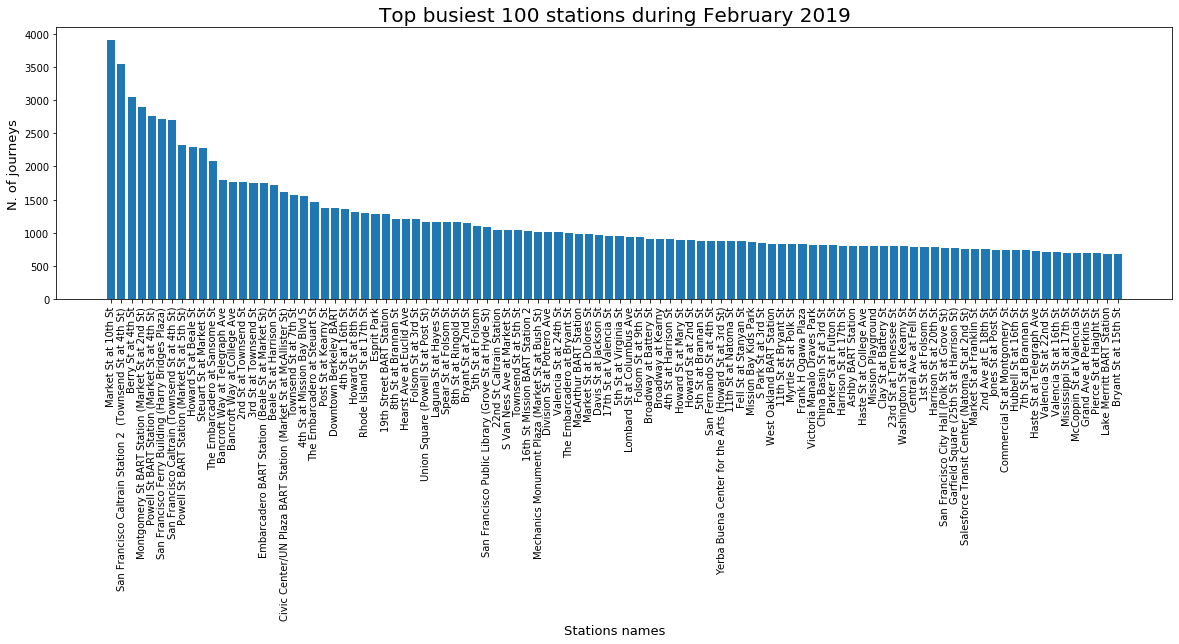

In [37]:
stations = bike_data["start_station_name"].value_counts().head(100)

plt.figure(figsize = [20,5])
plt.bar(data=stations, x=stations.index, height=stations.values)
plt.xticks(rotation=90);
plt.xlabel("Stations names", fontsize=13)
plt.ylabel("N. of journeys", fontsize=13)
plt.title("Top busiest 100 stations during February 2019", fontsize=20);

> **Observation:** Looks like _Market St at 10th St_ and _San Francisco Caltrain Station 2_ are the main station from where every renting service start. 

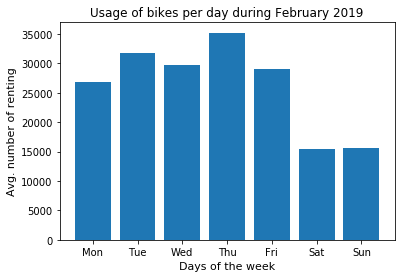

In [41]:
days = bike_data.weekday.value_counts(sort=False)

plt.bar(data=days, x=days.index, height=days.values);
plt.xlabel("Days of the week", fontsize=11)
plt.ylabel("Avg. number of renting", fontsize=11)
plt.title("Usage of bikes per day during February 2019", fontsize=12);

> **Observation:** Users prefer to rent bikes mostly during the week (perhaps to go to work?) with a peek on Thursdays. Number of renting during the weekend remain low but constant during Saturday and Sunday. 

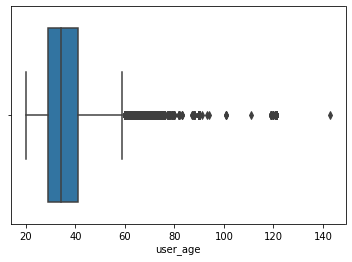

In [114]:
sb.boxplot(data=bike_data, x="user_age"); # A glance of users age. We can see many outliers. 

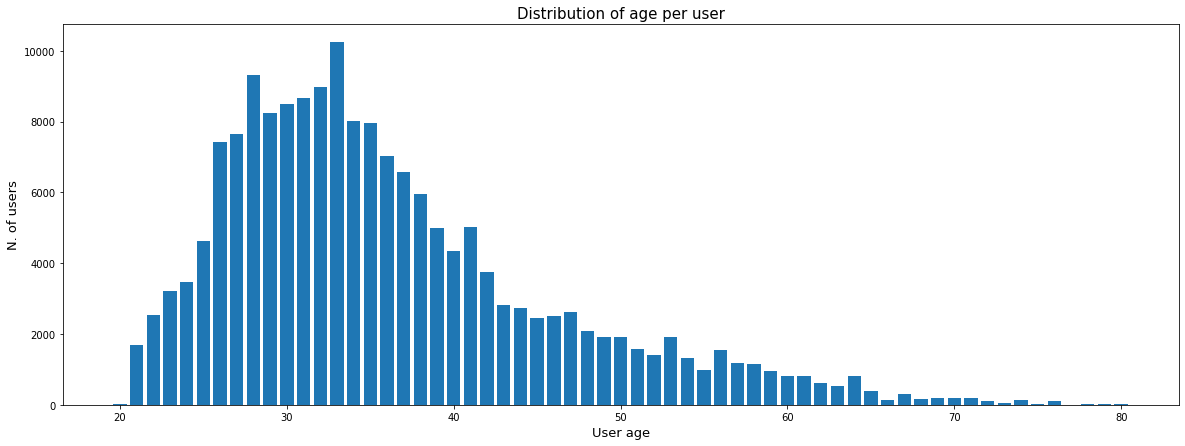

In [55]:
clean_age = bike_data[bike_data.user_age<=80] # Remove users with age above 80
ages = clean_age.groupby("user_age")["user_age"].count()

plt.figure(figsize = [20,7])
plt.bar(data=ages, x=ages.index, height=ages.values);
plt.xlabel("User age", fontsize=13)
plt.ylabel("N. of users", fontsize=13)
plt.title("Distribution of age per user", fontsize=15);

> **Observation:** The age distribution shows that the majority of users are young people between 27 and 35 years old. 

(-1, 10)

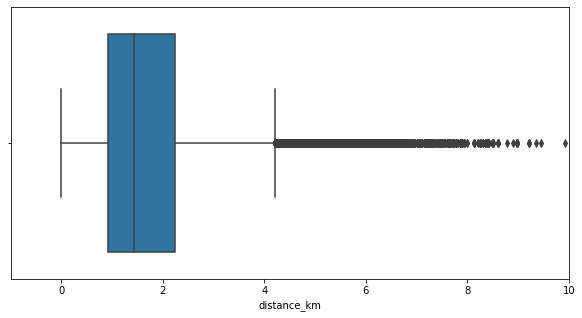

In [121]:
plt.figure(figsize=(10,5)) # An overview of the distance covered by users
sb.boxplot(data=bike_data, x="distance_km");
plt.xlim(-1,10)

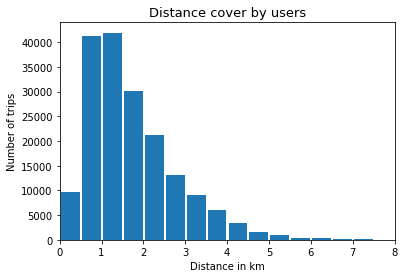

In [397]:
no_zero_km = bike_data.query("distance_km!=0")
bins = np.arange(no_zero_km["distance_km"].min(), no_zero_km["distance_km"].max()+0.5, 0.5)

plt.hist(no_zero_km["distance_km"], bins=bins, rwidth=0.9)
plt.xlim(0,8)
plt.xlabel("Distance in km")
plt.ylabel("Number of trips")
plt.title("Distance cover by users", fontsize=13);

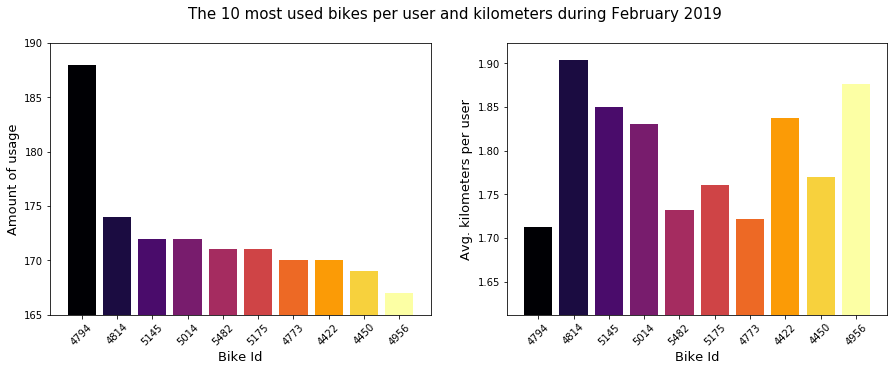

In [398]:
bikes_stat = no_zero_km.groupby("bike_id")["distance_km"].agg(["count","mean"]).sort_values(by=["count"],ascending=False).reset_index().head(10)

inferno = cm.get_cmap('inferno',10)

plt.figure(figsize = [15, 5])
plt.suptitle("The 10 most used bikes per user and kilometers during February 2019", fontsize=15);

plt.subplot(1, 2, 1) # plot to the left
plt.bar(data=bikes_stat, x="bike_id", height="count", color=inferno.colors)
plt.ylim(bikes_stat["count"].min()-2,bikes_stat["count"].max()+2)
plt.xticks(rotation=45)
plt.xlabel("Bike Id", fontsize=13)
plt.ylabel("Amount of usage", fontsize=13)

plt.subplot(1, 2, 2) # plot to the right
plt.bar(data=bikes_stat, x="bike_id", height="mean", color=inferno.colors)
plt.ylim(bikes_stat["mean"].min()-0.1,bikes_stat["mean"].max()+0.02) 
plt.xticks(rotation=45);
plt.xlabel("Bike Id", fontsize=13)
plt.ylabel("Avg. kilometers per user", fontsize=13);

> **Observation:** Both graphics show how import is to keep track of status of the bikes. As above showed bike id 4794 is the "customers' favorite" item. With an usage of almost 200 times per month and more than 1.70 kilometers per usage, it will certainly need maintenance in the nearest future.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> I decided to discard the bikes Id that had zero kilometers of usage. All this because geolocalization seems not to be working when a journey has the same start and end station.  

In [399]:
print(bike_data.distance_km.value_counts().head(1)) # Number of journey that had zero kilometers

0.0    3880
Name: distance_km, dtype: int64


### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> Yes, I found that many users ages were unlikely to be true. Perhaps wrong input data or simply fake information from users side. I decided to maintain my observation with a maximum age limit of 80.

In [122]:
bike_data[bike_data["user_age"]>80]["user_age"].sort_values(ascending=False).head(10) # Unlikely customers age

27370    143
78897    121
93193    121
62598    121
66700    121
72711    121
72819    121
73755    121
75686    121
88152    121
Name: user_age, dtype: Int64

## Bivariate Exploration

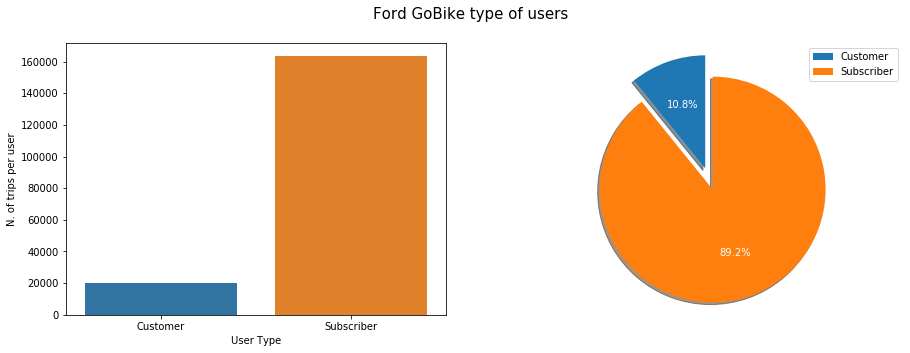

In [137]:
plt.figure(figsize = [15, 5])

plt.subplot(1,2,1)
sb.countplot(data=bike_data, x="user_type")
plt.xlabel('User Type')
plt.ylabel('N. of trips per user')

plt.subplot(1,2,2)
customer = bike_data.query('user_type == "Customer"')['bike_id'].count()
subscriber = bike_data.query('user_type == "Subscriber"')['bike_id'].count()

customer_proportion = customer / bike_data['bike_id'].count()
subscriber_proportion = subscriber / bike_data['bike_id'].count()

prop = [customer_proportion, subscriber_proportion]
plt.pie(prop, explode=(0, 0.2), autopct='%1.1f%%', textprops={'color':'white'}, startangle=90,shadow=True)
plt.axis('equal')
plt.legend(["Customer","Subscriber"])
plt.suptitle('Ford GoBike type of users', fontsize=15);

> **Observation:** We can see that almost 90% of Ford GoBike users are subscriber. 

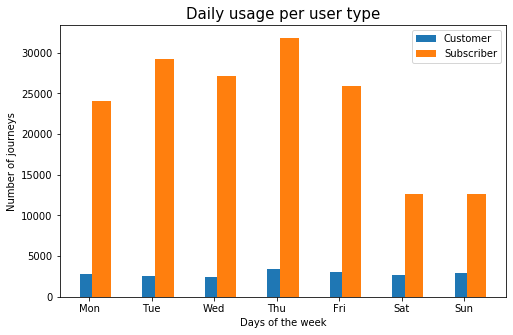

In [187]:
customer = bike_data.query('user_type == "Customer"').groupby("weekday")["bike_id"].count().reset_index()
subscriber = bike_data.query('user_type == "Subscriber"').groupby("weekday")["bike_id"].count().reset_index()

ind = np.arange(len(customer))
width = 0.2

plt.figure(figsize = [8, 5])
plt.bar(data=customer, x= ind, height="bike_id", label="Customer", width=0.3)
plt.bar(data=subscriber, x=ind+width, height="bike_id", label="Subscriber",width=0.3)
plt.xticks(customer.weekday.index, customer.weekday.values)
plt.xlabel("Days of the week")
plt.ylabel("Number of journeys")
plt.title("Daily usage per user type", fontsize=15)
plt.legend();

> **Observation:** Subscribers tend to use the most the rental service. We can also see how both groups (customers and subscribers) use bikes mostly during the week with a decrease during the weekend. Pattern that is more significant for the subscriber category. 

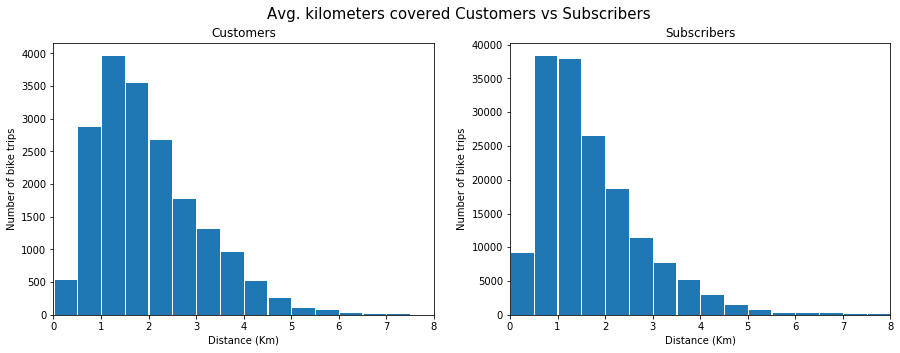

In [297]:
plt.figure(figsize = [15, 5])

plt.subplot(1,2,1)
dist_cust = bike_data.query('user_type == "Customer" & distance_km !=0')
bins = np.arange(dist_cust.distance_km.min(), dist_cust.distance_km.max(),0.5)
plt.hist(dist_cust.distance_km, bins=bins, rwidth=0.95)
plt.xlim(0,8)
plt.xlabel("Distance (Km)")
plt.ylabel("Number of bike trips")
plt.title("Customers");

plt.subplot(1,2,2)
dist_sub = bike_data.query('user_type == "Subscriber" & distance_km !=0')
bins = np.arange(dist_sub.distance_km.min(), dist_sub.distance_km.max(),0.5)
plt.hist(dist_sub.distance_km, bins=bins, rwidth=0.95);
plt.xlim(0,8)
plt.xlabel("Distance (Km)")
plt.ylabel("Number of bike trips")
plt.title("Subscribers");

plt.suptitle("Avg. kilometers covered Customers vs Subscribers", fontsize=15);

> **Observation:** We can see that on average customers type tend to have longer distances with a peak between  1 and 2 km per trip. On the other hand Subscribers are more constant in the use of bikes, even though they cover less distance per trip (between 0.5 and 1.5 km) their frequency of usage is much higher. 

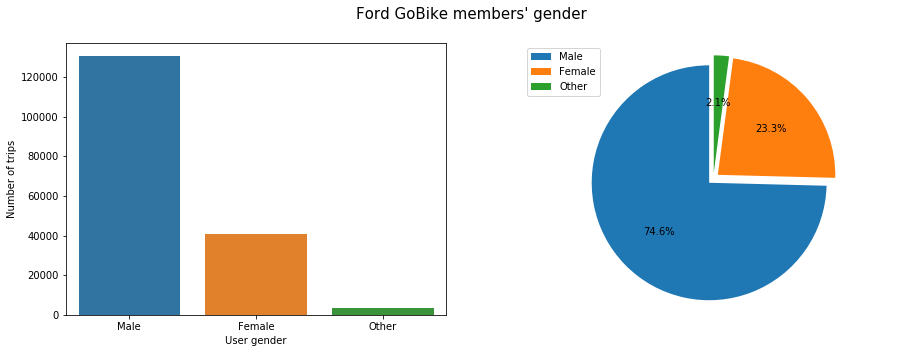

In [227]:
plt.figure(figsize = [15, 5])

plt.subplot(1,2,1)
sb.countplot(data=bike_data, x="member_gender", order=bike_data.member_gender.value_counts().index, hue_order="member_gender")
plt.xlabel('User gender')
plt.ylabel('Number of trips')

plt.subplot(1,2,2)
male = bike_data.query('member_gender == "Male"')['member_gender'].count()
female = bike_data.query('member_gender == "Female"')['member_gender'].count()
other = bike_data.query('member_gender == "Other"')['member_gender'].count()

male_prop = male / bike_data['member_gender'].count()
female_prop = female / bike_data['member_gender'].count()
other_prop = other / bike_data['member_gender'].count()

prop = [male_prop, female_prop, other_prop]
plt.pie(prop, autopct='%1.1f%%', explode=(0.05, 0.05, 0.05), startangle=90)
plt.axis('equal')
plt.legend(["Male", "Female", "Other"])
plt.suptitle("Ford GoBike members' gender", fontsize=15);

> **Observation:** The users gender composition is lead by males, with a 75%. Follow by females and others. To remark how the female proportion is less than half than males, which could lead to think about the comfort, design, or weight of the bikes. 

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> The main feature of interest is regarding the users group. From the graphics above we notice how 90% of users are subscribers that tend to use the rental service mostly during weekdays and covering between 0.5 and 1.5 km per trip. The other group of interest, customers, are composed by the remaining 10% of users that tend to use the rental service constantly every day (with a slightly but not significance decrease during the weekends), these users tend to cover higher distances per trip (between 1 and 2 kilometers). 

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Yes, I also observed how the users gender are not equally distributed. In fact, almost 75% of users are males, following by 24% of female which lead to think that the service could be further improve to attract more female customers. 

## Multivariate Exploration

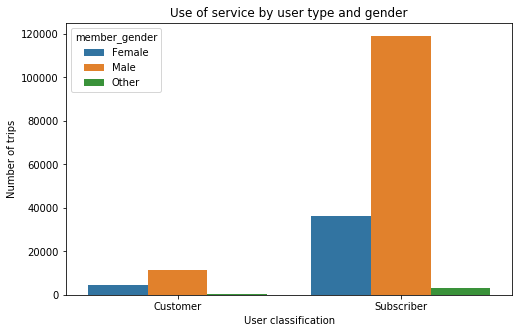

In [294]:
plt.figure(figsize = [8, 5])
sb.countplot(data=bike_data, x="user_type", hue="member_gender")
plt.title("Use of service by user type and gender")
plt.xlabel("User classification")
plt.ylabel("Number of trips");

> **Observation:** To confirm our findings from the previous graphics, we can see how Subscribers use the rental service the most and, not surprisingly, this trend is lead by men in both groups. To notice how this gap is more remarkable within the Subscribers group.

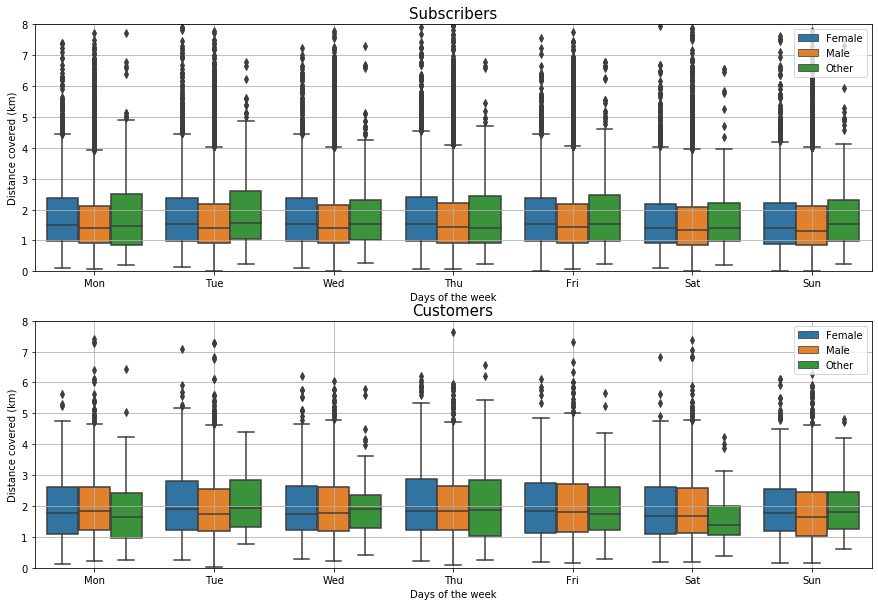

In [401]:
plt.figure(figsize = [15, 10])
plt.subplot(2,1,1)
sb.boxplot(data = dist_sub, x="weekday", y="distance_km", hue="member_gender")
plt.ylim(0,8)
plt.title("Subscribers", fontsize=15)
plt.ylabel("Distance covered (km)")
plt.xlabel("Days of the week")
plt.legend(loc=1)
plt.grid()

plt.subplot(2,1,2)
sb.boxplot(data = dist_cust, x="weekday", y="distance_km", hue="member_gender")
plt.ylim(0,8)
plt.title("Customers", fontsize=15)
plt.ylabel("Distance covered (km)")
plt.xlabel("Days of the week")
plt.legend(loc=1)
plt.grid();

> **Observation:** From above graphic we can see how Customers tend to cover more kilometers per day than Subscribers, and more fascinating is to see that, for both groups, men are on average "lazier" than women and others. Giving the idea that the service is mostly used by men to have a standard itinerary (perhaps just going to work?). 

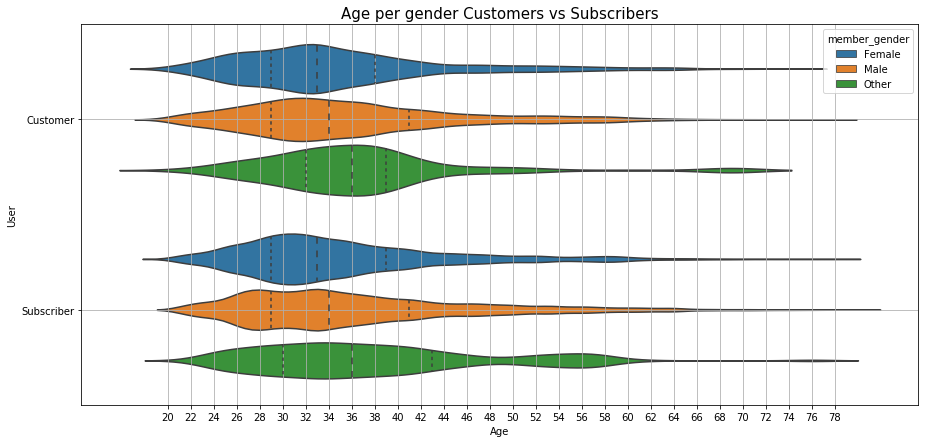

In [380]:
clean_age=clean_age.copy()
clean_age["user_age"] = clean_age["user_age"].astype(float)
bins = np.arange(clean_age.user_age.min(), clean_age.user_age.max(), 2)

plt.figure(figsize = [15, 7])
sb.violinplot(data=clean_age, y='user_type', x="user_age", hue="member_gender", inner="quartile")
plt.title("Age per gender Customers vs Subscribers", fontsize=15)
plt.ylabel("User")
plt.xticks(bins)
plt.xlabel("Age")
plt.grid();

> **Observation:** The plot shows that there is not such a big difference in age between males and females for both groups. To mention that the bulk of distribution leads to think that the service is mostly used by female and males between 30 and 34 years old for the Customer group, and 26 to 34 years old for the Subscriber group. In both cases the graphic shows how the other gender seems to be distributed within an older range of age, in fact, with a median of 36 and a bulk of data between 34 and 36 years old, this gender seems to be composed by major people.  

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> No, it seems that my variable were independent from each other. By observing one feature of interest (i.e. distance covered by each group) the other features stay the same.  

### Were there any interesting or surprising interactions between features?

> Yes, I noticed how the data confirmed was what said in the bivariate exploration. In addition, I noticed how, even though men are the majority of users in either customers and subscribers, females and others are the ones that seems to enjoy more a ride. They seem to cover more distance per journey than males. <br>
The distribution of age is pretty similar for males and females for both groups (Subscribers and Customers). It is important to mention how others seems to be composed by major people but I need to remind that they composed just the 2% of the population. Perhaps more data and for longer time would be necessary to have some more accurate conclusions. 